env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
[Errno 17] File exists: './logs/SuToBoCM - 79998s10e75000v 8888s0.97d'


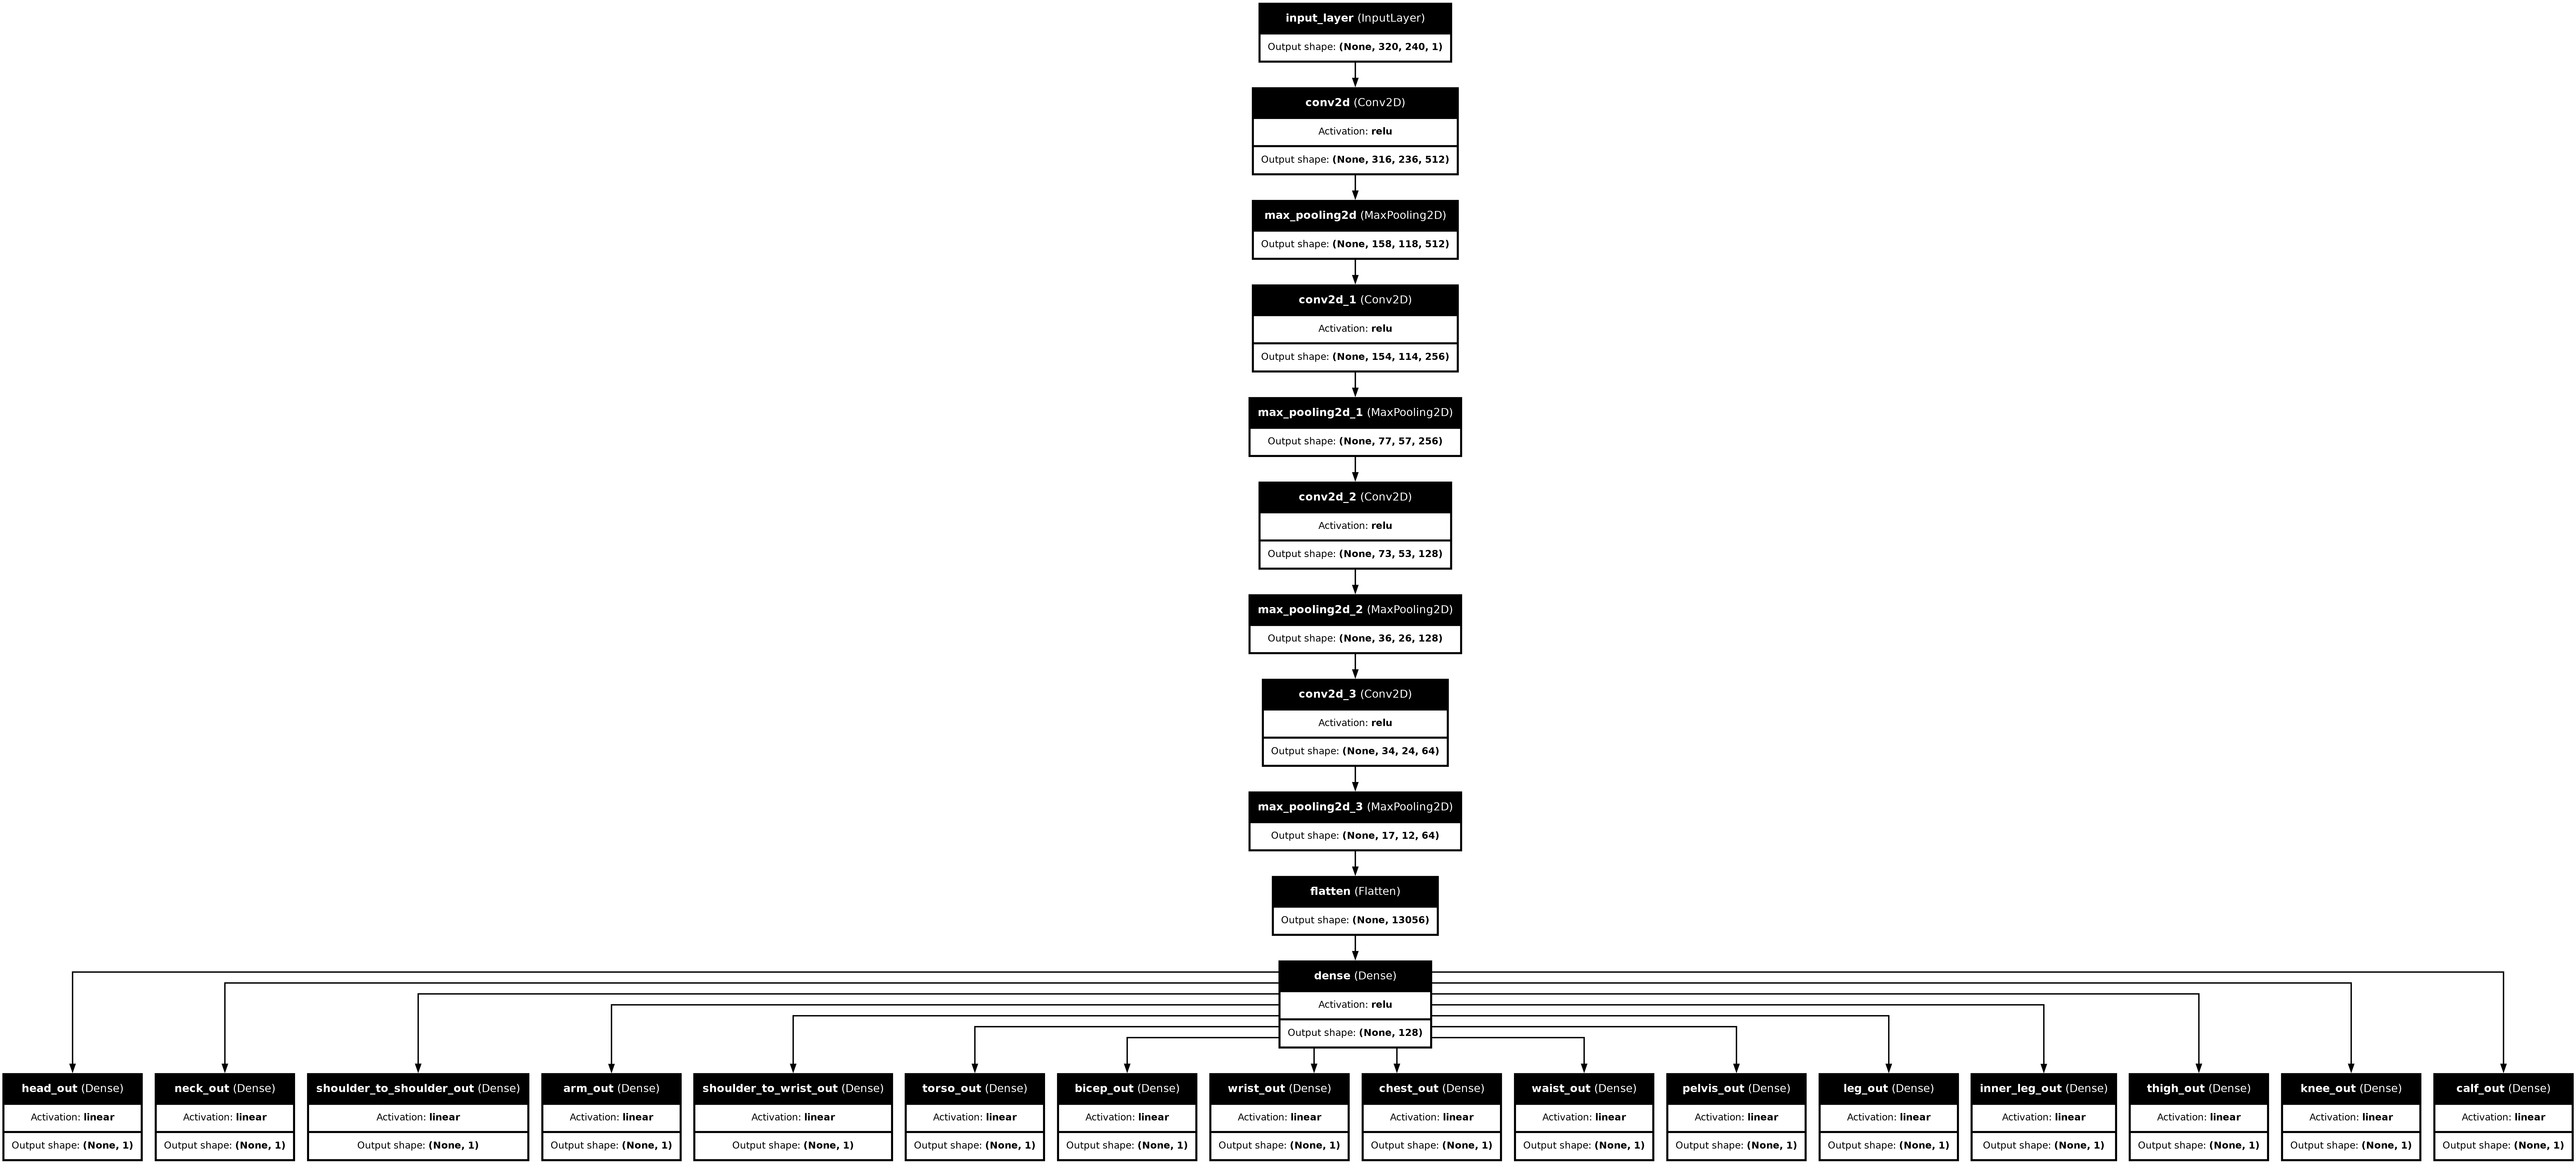

In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
import keras.utils
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
import os

inp = Input(shape=(320, 240, 1))

n_filters = 512
max_p = inp

for _ in range(3):
    conv = Conv2D(filters=n_filters, kernel_size=5, activation='relu')(max_p)
    max_p = MaxPooling2D(pool_size=(2, 2))(conv)
    
    n_filters //= 2

conv = Conv2D(filters=n_filters, kernel_size=3, activation='relu')(max_p)
max_p = MaxPooling2D(pool_size=(2, 2))(conv)

flatten = Flatten()(max_p)
dense = Dense(128, activation='relu')(flatten)

head_out = Dense(1, activation='linear', name='head_out')(dense)
neck_out = Dense(1, activation='linear', name='neck_out')(dense)
shoulder_to_shoulder_out = Dense(1, activation='linear', name='shoulder_to_shoulder_out')(dense)
arm_out = Dense(1, activation='linear', name='arm_out')(dense)
shoulder_to_wrist_out = Dense(1, activation='linear', name='shoulder_to_wrist_out')(dense)
torso_out = Dense(1, activation='linear', name='torso_out')(dense)
bicep_out = Dense(1, activation='linear', name='bicep_out')(dense)
wrist_out = Dense(1, activation='linear', name='wrist_out')(dense)
chest_out = Dense(1, activation='linear', name='chest_out')(dense)
waist_out = Dense(1, activation='linear', name='waist_out')(dense)
pelvis_out = Dense(1, activation='linear', name='pelvis_out')(dense)
leg_out = Dense(1, activation='linear', name='leg_out')(dense)
inner_leg_out = Dense(1, activation='linear', name='inner_leg_out')(dense)
thigh_out = Dense(1, activation='linear', name='thigh_out')(dense)
knee_out = Dense(1, activation='linear', name='knee_out')(dense)
calf_out = Dense(1, activation='linear', name='calf_out')(dense)



model = Model(
    inputs=inp,
    outputs=[
        head_out,
        neck_out,
        shoulder_to_shoulder_out,
        arm_out,
        shoulder_to_wrist_out,
        torso_out,
        bicep_out,
        wrist_out,
        chest_out,
        waist_out,
        pelvis_out,
        leg_out,
        inner_leg_out,
        thigh_out,
        knee_out,
        calf_out
    ],
    name='conv_bodies'
)


###TRAINING VARIABLES

sample_count = 79998
epoch_count = 10
validation_count = 75000
initial_learning_rate=.001
decay_steps=8888
decay_rate=0.97
dataset_name = "SuToBoCM"

folder_path = f"{dataset_name} - {sample_count}s{epoch_count}e{validation_count}v {"" if initial_learning_rate == 0.001 else initial_learning_rate + "ilr"}{decay_steps}s{decay_rate}d"

try:
    os.mkdir(os.path.join("./logs/" + folder_path))
except OSError as error:
    print(error)
    

#model.save_weights("default.weights.h5")

#model.summary()

# from keras.utils import plot_model
# 
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [2]:
import os
import cv2
import random

class Database_Loader(keras.utils.Sequence):
    
    def __init__(self, image_location, data_location, sample_count, batch_size, dataset = "Surreact", shuffle=True, seed=0, input_dimensions=(240, 320), prefix="Avatar_", use_memory=False, load_data = True, random_sample = False):
        self.image_location = image_location
        self.data_location = data_location
        self.sample_count = sample_count
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.input_dimensions = input_dimensions
        self.prefix = prefix
        self.use_memory = use_memory
        self.load_data = load_data
        self.random_sample = random_sample
        self.dataset = dataset

        if self.random_sample:
            self.IDs = random.sample(range(len(os.listdir(self.image_location))),self.sample_count)
        else:
            self.IDs = [x for x in range(self.sample_count)]
            self._load_data()

        super().__init__(workers=2, use_multiprocessing=True)
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(self.sample_count / self.batch_size))
    
    
    def _load_data(self):
        if self.load_data:
            self.data = dict()
            for index in self.IDs:
                self.data[index] = np.load(os.path.join(self.data_location + self.prefix + f"{index:06d}.npy"))

        if self.use_memory:
            self.images = dict()
            for index in self.IDs:
                self.images[index] = cv2.imread(os.path.join(self.image_location + self.prefix + f"{index:06d}.png"), cv2.IMREAD_GRAYSCALE)
    
    def __getitem__(self, index):
        X = np.empty(shape=(self.batch_size, 320, 240))
        y = {
            # 'head_out': [],
            # 'neck_out': [],
            'shoulder_to_shoulder_out': [],
            'arm_out': [],
            'shoulder_to_wrist_out': [],
            # 'torso_out': [],
            'bicep_out': [],
            'wrist_out': [],
            'chest_out': [],
            'waist_out': [],
            'pelvis_out': [],
            'leg_out': [],
            'inner_leg_out': [],
            'thigh_out': [],
            # 'knee_out': [],
            'calf_out': []
        }



        start_index = index * self.batch_size + 1
        
        for i in range(self.batch_size):
            name = f"{self.IDs[(start_index + i)%self.sample_count]:06d}"
            
            if self.load_data:
                current_measurement = self.data[self.IDs[(start_index + i)%self.sample_count]][:-1]          
            else:
                current_measurement = np.load(os.path.join(self.data_location + self.prefix + name + ".npy"))[:-1]
                
            if self.use_memory:
                X[i,] = self.images[self.IDs[(start_index + i)%self.sample_count]]
                
            else:
                X[i,] = cv2.imread(os.path.join(self.image_location + self.prefix + name + ".png"), cv2.IMREAD_GRAYSCALE)
                
            if self.dataset == "Surreact":
                # y['head_out'].append([current_measurement[0]])
                # y['neck_out'].append([current_measurement[1]])
                y['shoulder_to_shoulder_out'].append([current_measurement[2]])
                y['arm_out'].append([current_measurement[3]])
                y['shoulder_to_wrist_out'].append([current_measurement[4]])
                # y['torso_out'].append([current_measurement[5]])
                y['bicep_out'].append([current_measurement[6]])
                y['wrist_out'].append([current_measurement[7]])
                y['chest_out'].append([current_measurement[8]])
                y['waist_out'].append([current_measurement[9]])
                y['pelvis_out'].append([current_measurement[10]])
                y['leg_out'].append([current_measurement[11]])
                y['inner_leg_out'].append([current_measurement[12]])
                y['thigh_out'].append([current_measurement[13]])
                # y['knee_out'].append([current_measurement[14]])
                y['calf_out'].append([current_measurement[15]])
            

        for key, value in y.items():
            y[key] = np.array(value)
            
        return X, y
    
    def on_epoch_end(self):
        if self.random_sample:
            self.IDs = random.sample(range(len(os.listdir(self.image_location))),self.sample_count)
            self._load_data()

        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(self.IDs)
        else:
            self.IDs = np.arange(self.sample_count)
         

In [12]:
quickTrain = {
                'image_location': "../Surreact-APose/train/imgs_nobg_frontEDITED/", 
                'data_location': "../Surreact-APose/train/measurementsCM/", 
                'sample_count': 18, 
                'batch_size': 9, 
                'seed': 69, #np.random.randint(0, 10000), 
                'use_memory': False,
                'random_sample': True,
                'shuffle': True}

quickValidate = {
                'image_location': "../Surreact-APose/train/imgs_nobg_frontEDITED/",
                'data_location': "../Surreact-APose/train/measurementsCM/",
                'sample_count': sample_count,
                'batch_size': 9,
                'seed': 69, #np.random.randint(0, 10000),
                'use_memory': False,
                'random_sample': False}

realDataTest = {
                'image_location': "../bodym-dataset/front/images/",
                'data_location': "../bodym-dataset/front/measurements/",
                'sample_count': 8978,
                'batch_size': 4,
                'use_memory': False,
                'random_sample': False,
                'shuffle': False}

train_generator = Database_Loader(**quickTrain)
validation_generator = Database_Loader(**quickValidate)

In [4]:
# from keras.models import load_model
# 
# model = load_model('')

In [13]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.losses import MeanSquaredError
from keras_tqdm import TQDMNotebookCallback


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss={
        # 'head_out': MeanSquaredError(),
        # 'neck_out': MeanSquaredError(),
        'shoulder_to_shoulder_out': MeanSquaredError(),
        'arm_out': MeanSquaredError(),
        'shoulder_to_wrist_out': MeanSquaredError(),
        # 'torso_out': MeanSquaredError(),
        'bicep_out': MeanSquaredError(),
        'wrist_out': MeanSquaredError(),
        'chest_out': MeanSquaredError(),
        'waist_out': MeanSquaredError(),
        'pelvis_out': MeanSquaredError(),
        'leg_out': MeanSquaredError(),
        'inner_leg_out': MeanSquaredError(),
        'thigh_out': MeanSquaredError(),
        # 'knee_out': MeanSquaredError(),
        'calf_out': MeanSquaredError()
    },
    # loss_weights={
    #     'head_out': 2.0,
    #     'neck_out': 1.0,
    #     'shoulder_to_shoulder_out': 2.0,
    #     'arm_out': 1.0,
    #     'shoulder_to_wrist_out': 1.0,
    #     'torso_out': 1.0,
    #     'bicep_out': 1.0,
    #     'wrist_out': 1.0,
    #     'chest_out': 1.0,
    #     'waist_out': 1.0,
    #     'pelvis_out': 1.0,
    #     'leg_out': 1.0,
    #     'inner_leg_out': 3.0,
    #     'thigh_out': 1.0,
    #     'knee_out': 1.0,
    #     'calf_out': 1.0
    # },
    # loss='mse',
    metrics={
        # 'head_out': ['mae'],
        # 'neck_out': ['mae'],
        'shoulder_to_shoulder_out': ['mae'],
        'arm_out': ['mae'],
        'shoulder_to_wrist_out': ['mae'],
        # 'torso_out': ['mae'],
        'bicep_out': ['mae'],
        'wrist_out': ['mae'],
        'chest_out': ['mae'],
        'waist_out': ['mae'],
        'pelvis_out': ['mae'],
        'leg_out': ['mae'],
        'inner_leg_out': ['mae'],
        'thigh_out': ['mae'],
        # 'knee_out': ['mae'],
        'calf_out': ['mae']
    },
)
keras.utils.set_random_seed(42)


checkpoint_filepath = './models/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True)

model.fit(
    x=train_generator,
    validation_data=validation_generator,
    callbacks=[
        
        #TensorBoard(write_graph=False,log_dir="./logs/"+folder_path),
        TQDMNotebookCallback(separator="", metric_format="{name}: {value:0.8f} || "),
        model_checkpoint_callback,
    ],
    batch_size=9,
    epochs=epoch_count,
    verbose=0
)

model.save("./models/full/model.keras")
# 
# for i in range(10000):
#     image = cv2.imread(f"../Surreact-APose/train/imgs_nobg_frontEDITED/Avatar_{6969+i:06d}.png", cv2.IMREAD_GRAYSCALE)
# 
#     print(model.predict(np.array([image])))
#     

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

Process Keras_worker_ForkPoolWorker-151:
Process Keras_worker_ForkPoolWorker-152:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/usr/lib/python3.12/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 386, in get
    with self._rlock:
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 387, in get
    res = self._reader.recv_byte

KeyboardInterrupt: 

  File "/usr/lib/python3.12/multiprocessing/connection.py", line 395, in _recv
    chunk = read(handle, remaining)
            ^^^^^^^^^^^^^^^^^^^^^^^


In [ ]:
# from keras.models import load_model
# import cv2
# import numpy as np
# model = load_model("./models/checkpoint.model.keras")
# 
# #ankle	arm-length	bicep	calf	chest	forearm	height	hip	leg-length	shoulder-breadth	shoulder-to-crotch	thigh	waist	wrist
# 
# 
# def printResults(name, val1, val2):
#     if val2 == "N/A":
#         print(name, " - ", val1, val2)
#         return 
#     print(name, " - ", val1, val2, " error - ", abs(val1 - val2))
# 
# 
# 
# 
# for i in range(1):
#     image = cv2.imread(f"../bodym-dataset/front/images/Avatar_{i:06d}.png", cv2.IMREAD_GRAYSCALE)
#     data = np.load(f"../bodym-dataset/front/measurements/Avatar_{i:06d}.npy")
#     predictions = model.predict(np.array([image]))
#     printResults("Head", predictions[0], "N/A")
#     printResults("Neck", predictions[1], "N/A")
#     printResults("Shoulder to shoulder", predictions[2], data[9]/100)
#     printResults("Shoulder to wrist", predictions[3], data[1]/100)
#     printResults("Torso", predictions[4], "N/A")
#     printResults("Bicep", predictions[5], data[2]/100)
#     printResults("Wrist", predictions[6], data[13]/100)
#     printResults("Chest", predictions[7], data[4]/100)
#     printResults("Waist", predictions[8], data[12]/100)
#     printResults("Pelvis", predictions[9], data[6]/100)
#     printResults("Inner leg", predictions[10], data[7]/100)
#     printResults("Thigh", predictions[11], data[11]/100)
#     printResults("Knee", predictions[12], "N/A")
#     printResults("Calf", predictions[13], data[3]/100)
    

In [ ]:
#Data modifiaction

# import os
# from tqdm import tqdm
# 
# avatar_count = 79999
# counter = 0
# 
# for number in tqdm(range(avatar_count)):
#     file = (tuple(np.load(f"../Surreact-APose/train/measurements/Avatar_{number:06d}.npy", allow_pickle=True)))
#     measurements = []
#     for value in file:
#         measurements.append(float(value * 100))
#     np.save(f"../Surreact-APose/train/measurementsCM/Avatar_{counter:06d}", measurements)
#     counter += 1

In [ ]:
# #Image modification
# 
# import os
# import cv2
# import numpy as np
# from tqdm import tqdm
# 
# 
# avatar_count = 79999
# counter = 0
# 
# for number in tqdm(range(avatar_count)):
#     if number == 5:
#         continue
#     image = cv2.imread(f"../Surreact-APose/train/imgs_nobg_front/Avatar_{number:06d}.png", cv2.IMREAD_UNCHANGED)
#     alpha_channel = image[:, :, 3]
#     body_indices = alpha_channel > 30
#     image[body_indices] = [255, 255, 255, 255]
#     indices = np.where(body_indices)
#     leftmost_pixel = np.min(indices[1])
#     rightmost_pixel = np.max(indices[1])
#     topmost_pixel = max(np.min(indices[0]), 0)
#     bottommost_pixel = min(np.max(indices[0]), 239)
#     image = cv2.cvtColor(image, cv2.COLOR_mRGBA2RGBA)
#     cropped = image[topmost_pixel:bottommost_pixel, leftmost_pixel:rightmost_pixel]
# 
#     border_height = 320 - cropped.shape[0]
#     border_width = 240 - cropped.shape[1]
# 
#     # Calculate the border sizes
#     top_border = border_height // 2
#     bottom_border = border_height - top_border
#     left_border = border_width // 2
#     right_border = border_width - left_border
# 
#     # Add the border
#     bordered_image = cv2.copyMakeBorder(cropped, top_border, bottom_border, left_border, right_border, cv2.BORDER_CONSTANT, value=(0,0,0,0))
# 
# 
#     cv2.imwrite(f"../Surreact-APose/train/imgs_nobg_frontEDITED/Avatar_{counter:06d}.png", bordered_image)
#     counter +=1

In [ ]:
#FOR BODY_M DATASET
# import csv
# import numpy as np
# import os
# 
# import cv2
# import tqdm.notebook
# 
# counter = 0
# for folder in tqdm.notebook.tqdm(["train","testA","testB"]):
# 
#     with open('../bodym-dataset/'+folder+'/subject_to_photo_map.csv', 'r') as f:
#         reader = csv.reader(f)
#         uuid_raw = list(reader)
#     from collections import defaultdict
#     
#     uuid_map = defaultdict(list)
#     
#     for subject_id, photo_id in uuid_raw[1:]:
#         uuid_map[subject_id].append(photo_id)
#     image_data = {}
#     
#     with open('../bodym-dataset/'+folder+'/measurements.csv', 'r') as f:
#         reader = csv.reader(f)
#     
#         for line in reader:
#             subject_id = line[0]
#     
#     
#             for image_id in uuid_map[subject_id]:
#                 image_data[image_id] = np.array(list(map(float, line[1:])))
#     
#     
#     for subject_id, images in tqdm.notebook.tqdm(uuid_map.items()):
#         for image in images:
#             measurements = np.array(image_data[image])
#             silhouette = cv2.imread(os.path.join('../bodym-dataset/'+folder+'/mask/' + image + '.png'), cv2.IMREAD_GRAYSCALE)
#             silhouette = cv2.resize(silhouette,(240, 320)) #may be wrong
#             cv2.imwrite(os.path.join(f'../bodym-dataset/front/images/Avatar_{counter:06d}.png'), silhouette)
#             np.save(os.path.join(f'../bodym-dataset/front/measurements/Avatar_{counter:06d}.npy'), measurements)
#             counter += 1
